# Case 1 - Load Factor Prediction

In [21]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)  # suppress scientific notation
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.model_selection import KFold
from sklearn import linear_model 
import scipy . linalg as lng
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Libraries for LASSO Rgression (LARS)
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

In [2]:
# import original xlsx
df = pd.read_excel('Realized Schedule 20210101-20220208.xlsx')

In [3]:
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,VW,986,YYZ,320,J,CA,180,0.522222
36766,2022-02-08 19:30:00,LJ,579,YQU,319,J,CA,156,0.532051
36767,2022-02-08 19:40:00,LJ,506,YUL,319,J,CA,156,0.602564
36768,2022-02-08 19:05:00,CL,2708,DAN,73H,J,US,189,0.417989


In [4]:
################################
#Process 'ScheduleTime' Feature#
################################
df.insert(1,'Year', df['ScheduleTime'].dt.year)  # insert a column for year

# calculate days passed from the first day of the year (xxxx-01-01 00:00:00)
df.insert(2,'DateReference', pd.to_datetime(df['Year'].astype(str) + '-01-01 00:00:00'))
df.insert(3,'DaysPassed', 
         ((df['ScheduleTime'] - df['DateReference'])/pd.Timedelta(1, 'd')).fillna(0).astype(int))
# calculate minutes passed from the beginning of the day (00:00:00)
df.insert(4,'MinutesPassed', (df['ScheduleTime'].dt.hour * 60 + df['ScheduleTime'].dt.minute).astype(int))
# calculate day of week (Monday - 0; Sunday - 6)
df.insert(5,'DayOfWeek', (df['ScheduleTime'].dt.dayofweek).astype(int))
df = df.drop('DateReference', 1)

/var/folders/sc/txnrpgjj3_d8xd92sh09mddr0000gn/T/ipykernel_5794/363476474.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('DateReference', 1)


In [5]:
# force types of each column
df['Year'] = df['Year'].astype(int)
df['DaysPassed'] = df['DaysPassed'].astype(int)
df['MinutesPassed'] = df['MinutesPassed'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['Airline'] = df['Airline'].astype(str)
df['FlightNumber'] = df['FlightNumber'].astype(int)
df['Destination'] = df['Destination'].astype(str)
df['AircraftType'] = df['AircraftType'].astype(str)
df['FlightType'] = df['FlightType'].astype(str)
df['Sector'] = df['Sector'].astype(str)
df['SeatCapacity'] = df['SeatCapacity'].astype(int)
df['LoadFactor'] = df['LoadFactor'].astype(float)

In [6]:
df

,ScheduleTime,Year,DaysPassed,MinutesPassed,DayOfWeek,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,2021,0,395,4,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,2021,0,635,4,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,2021,0,725,4,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,2021,0,800,4,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,2021,0,860,4,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,2022,38,1110,1,VW,986,YYZ,320,J,CA,180,0.522222
36766,2022-02-08 19:30:00,2022,38,1170,1,LJ,579,YQU,319,J,CA,156,0.532051
36767,2022-02-08 19:40:00,2022,38,1180,1,LJ,506,YUL,319,J,CA,156,0.602564
36768,2022-02-08 19:05:00,2022,38,1145,1,CL,2708,DAN,73H,J,US,189,0.417989


In [7]:
data = df.iloc[:, 1:].values  # dataframe to numpy after pre-processing, discard initial 'ScheduleTime'

################
#Label encoders#
################

# Year
le_year = LabelEncoder()
data[:, 0] = le_year.fit_transform(data[:, 0])
# data[:, 0] = le_year.inverse_transform(data[:, 0].astype(int))

# Airline
le_airline = LabelEncoder()
data[:, 4] = le_airline.fit_transform(data[:, 4])
# data[:, 4] = le_airline.inverse_transform(data[:, 4].astype(int))

# FlightNumber
le_flight_number = LabelEncoder()
data[:, 5] = le_flight_number.fit_transform(data[:, 5])
# data[:, 5] = le_flight_number.inverse_transform(data[:, 5].astype(int))

# Destination 
le_destination = LabelEncoder()
data[:, 6] = le_destination.fit_transform(data[:, 6])
# data[:, 6] = le_destination.inverse_transform(data[:, 6].astype(int))

# AircraftType
le_aircraft_type = LabelEncoder()
data[:, 7] = le_aircraft_type.fit_transform(data[:, 7])
# data[:, 7] = le_aircraft_type.inverse_transform(data[:, 7].astype(int))

# FlightType
le_flight_type = LabelEncoder()
data[:, 8] = le_flight_type.fit_transform(data[:, 8])
# data[:, 8] = le_flight_type.inverse_transform(data[:, 8].astype(int))

# Sector
le_sector = LabelEncoder()
data[:, 9] = le_sector.fit_transform(data[:, 9])
# data[:, 9] = le_sector.inverse_transform(data[:, 9].astype(int))

data = data.astype(float)

> $\textbf{raw_data}$ is the unstandardized version and should never be changed

In [8]:
raw_data = data
print(raw_data.shape)
print(raw_data)

(36770, 12)
[[   0.            0.          395.         ...   11.
   142.            0.4084507 ]
 [   0.            0.          635.         ...    1.
    74.            0.18918919]
 [   0.            0.          725.         ...   11.
   142.            0.57042254]
 ...
 [   1.           38.         1180.         ...    1.
   156.            0.6025641 ]
 [   1.           38.         1145.         ...   11.
   189.            0.41798942]
 [   1.           38.         1235.         ...   11.
   189.            0.4973545 ]]


In [9]:
# calculate the mean and standard deviation of two ratio features
# seat capacity
seat_capacity_mean = np.mean(data[:, -2])
seat_capacity_std = np.std(data[:, -2])
print('The mean of seat capacity is {}'.format(seat_capacity_mean))
print('The standard deviation of seat capacity is {}'.format(seat_capacity_std))
# load factor
load_factor_mean = np.mean(data[:, -1])
load_factor_std = np.std(data[:, -1])
print('The mean of load factor is {}'.format(load_factor_mean))
print('The standard deviation of load factor is {}'.format(load_factor_std))

The mean of seat capacity is 155.28550448735382
The standard deviation of seat capacity is 58.850999210500184
The mean of load factor is 0.531752306575933
The standard deviation of load factor is 0.2721886897792685


In [10]:
# standardize a single feature
def standardization(feature):
    new_feature = (feature - np.mean(feature)) / np.std(feature)
    return new_feature

# DaysPassed
# data[:, 1] = standardization(data[:, 1])
# MinutesPassed
# data[:, 2] = standardization(data[:, 2])
# SeatCapacity
# data[:, -2] = standardization(data[:, -2])
# LoadFactor
# data[:, -1] = standardization(data[:, -1])

# standardize multiple features (a matrix of features)
def standardize_X(features):
    new_features = np.zeros((np.shape(features)[0], np.shape(features)[1]))
    for i in range(np.shape(new_features)[1]):
        new_features[:, i] = standardization(features[:, i])
    return new_features

In [11]:
y_ols = standardization(data[:, -1])  # target - standardized
X_ols = standardize_X(data[:, :-1])  # features - standardized

/var/folders/sc/txnrpgjj3_d8xd92sh09mddr0000gn/T/ipykernel_5794/1833353401.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


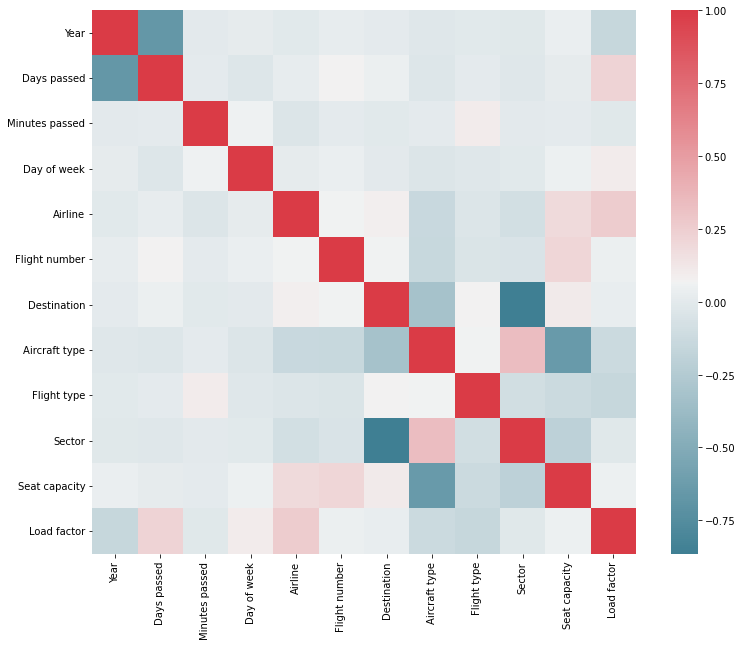

In [12]:
# correlation heatmap of processed data
df2 = pd.DataFrame(standardize_X(data), 
                   columns=['Year', 'Days passed', 'Minutes passed',
                           'Day of week', 'Airline', 'Flight number', 'Destination', 'Aircraft type',
                           'Flight type', 'Sector', 'Seat capacity', 'Load factor'])
f, ax = plt.subplots(figsize=(12.5, 10))
corr = df2.corr() # calculates Pearsons coff.
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig("corr_matrix.png", bbox_inches='tight',dpi=1000)

## Ordinary Least Squares (OLS) - baseline

In [16]:
beta_ols, _, _, _ = lng.lstsq(X_ols, y_ols)
yhat_ols = np.sum(beta_ols*X_ols, axis=1)
MSE_ols = np.sum((y_ols - yhat_ols)**2)/np.size(y_ols)
print('Weights for OLS regression: \n {}'.format(beta_ols))
print('MSE for OLS regression: {}'.format(MSE_ols))

# AIC and BIC
e = y_ols - X_ols @ beta_ols
err = np.sum(e ** 2) / n
inner = np.linalg.inv(X_ols.T @ X_ols * np.eye(p))
outer = (X_ols @ inner) @ X_ols.T
D[j] = np.trace(outer)
AIC = err + 2 * D[j] / n * s ** 2
BIC = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

Weights for OLS regression: 
 [-0.01728589  0.21018074  0.00062174  0.09715914  0.24974766  0.01113258
 -0.02975806 -0.15175949 -0.14755349  0.00218826 -0.11808072]
MSE for OLS regression: 0.8403127349911685


Feature: 0, Score: -0.01729
Feature: 1, Score: 0.21018
Feature: 2, Score: 0.00062
Feature: 3, Score: 0.09716
Feature: 4, Score: 0.24975
Feature: 5, Score: 0.01113
Feature: 6, Score: -0.02976
Feature: 7, Score: -0.15176
Feature: 8, Score: -0.14755
Feature: 9, Score: 0.00219
Feature: 10, Score: -0.11808


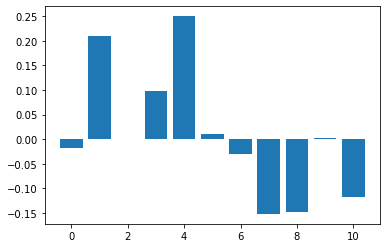

In [41]:
# Bar chart feature impotance
for i,v in enumerate(beta_ols):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(beta_ols))], beta_ols)
plt.savefig("Figures/hist_feature_importance.png", bbox_inches='tight',dpi=1000)
plt.show()

## Ridge Regression with Cross validation
$L_2$-regularization with $K=10$ fold cross-validation and one-standard-error rule to select the optimal $\lambda$.

In [25]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [26]:
def centerData(data):
    mu = np.mean(data,axis=0)
    centered_data = data - mu  
    return centered_data, mu

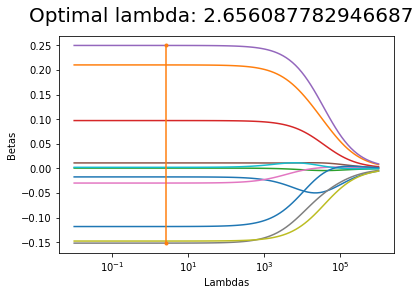

In [27]:
X_rr = raw_data[:, :-1]  # without standardization
y_rr = raw_data[:, -1]  # without standardization

X_rr_std = standardize_X(X_rr)  # apply standardization - standardized
y_rr_std = standardization(y_rr)  # apply standardization - standardized

# n - the number of observations; p - the number of features
[n, p] = np.shape(X_rr)

K = 10 # the number folds
k = 100 # the number of lambdas investigated 
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-2, 6, k)
MSE = np.zeros((10, 100))

betas = np.zeros((p,k))  # p - the number of features which equals to the dimension of betas
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_rr_std, lambdas[i], p, y_rr_std)

for i in range(1, K+1):
    
    # Select the train/test data in this fold
    XTrain = X_rr[i != I, :]
    yTrain = y_rr[i != I]
    XTest = X_rr[i == I, :]
    yTest = y_rr[i == I]
    
    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)
    
    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)
    
    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data
    
    #Fit ridgeregression
    for j in range(100):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)

        
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

In [28]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.

seMSE = np.std(MSE, axis = 0) / np.sqrt(K)  # standard error
# print(meanMSE)
# print(np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE))
J = np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE)[0]  # select lambda satisfy this criteria
j = int(J[-1:])  # choose the last one - largest lambda
Lambda_CV_1StdRule = lambdas[j]
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 3.20


In [29]:
beta_rr = ridgeMulti(X_rr_std, Lambda_CV_1StdRule, p, y_rr_std)
yhat_rr = np.sum(beta_rr*X_rr_std, axis=1)
MSE_rr = np.sum((y_rr_std - yhat_rr)**2)/np.size(y_rr_std)
print('Weights for Ridge Regression: \n {}'.format(beta_rr))
print('MSE for Ridge Regression: {}'.format(MSE_rr))

Weights for Ridge Regression: 
 [-0.01730593  0.21014929  0.00062005  0.09715031  0.24972344  0.01113202
 -0.02972988 -0.15172197 -0.14753909  0.00220633 -0.11803783]
MSE for Ridge Regression: 0.8403127373276928


> Summary of Ridge Regression: It has no improvement comparing with OLS and even slightly worse cause the model is too simple to predict the result. 

## The Lasso
- features selection with Least Angle Regression Selection(LARS) Algorithm and Cyclical Coordinate Descent(soft thresholding)

### LARS

In [30]:
X_lars = raw_data[:, :-1]  # without standardization
y_lars = raw_data[:, -1]  # without standardization

X_lars_std = standardize_X(X_lars)  # apply standardization - standardized
y_lars_std = standardization(y_lars)  # apply standardization - standardized

CV = 10  # 10-fold cross-validation

kf = KFold(n_splits=CV)
stop = n-math.ceil(n/CV)
K = range(stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

# Lars
for i, (train_index, test_index) in enumerate(kf.split(X_lars)):
    ytrain = y_lars[train_index].ravel() # ravel collapses the array, ie dim(x,1) to (x,)
    ytest = y_lars[test_index].ravel() 
    Xtrain = X_lars[train_index]
    Xtest = X_lars[test_index]

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest - mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(Xtrain.T) # Calculate training normalizer
    normalizer_test = preproc.Normalizer().fit(Xtest.T) # Calculate testing normalizer
    Xtrain = normalizer_train.transform(Xtrain.T).T # normalize training data
    Xtest = normalizer_test.transform(Xtest.T).T # normalize test data

    # compute all LARS solutions
    for j in K:
        # it is somewhat like forward step regression
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(Xtrain,ytrain)
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = Xtrain @ beta
        YhatTest = Xtest @ beta
        
        Err_tr[i-1, j] = np.mean((YhatTr-ytrain)**2) # training error
        Err_tst[i-1, j] = np.mean((YhatTest-ytest)**2) # test error
        
err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [31]:
Betas = np.zeros((p, n))
for j in range(n):
    reg = linear_model.Lars(n_nonzero_coefs=j, normalize=True)
    reg.fit(X_lars_std,y_lars_std)
    Betas[:,i] = reg.coef_

In [32]:
for j in range(len(K)):
    Yhat = X_lars_std @ Betas[:,K[j]]

In [33]:
print('MSE for Lasso with LARS: {}'.format(np.mean(((y_lars_std-Yhat)**2))))

MSE for Lasso with LARS: 1.0000000000000002


# Sklearn LASSO regression (LARS) on AIC & BIC

In [34]:
start_time = time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X_lars, y_lars)
fit_time = time.time() - start_time

In [35]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [37]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X_lars, y_lars)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

In [38]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.07026145126225136,36770.000000,36770.000000
0.06131255373063338,36187.623007,36196.135444
0.04172061684564869,34227.840775,34244.865650
0.0268655179747027,32766.924354,32792.461666
0.0247847422097009,32561.593670,32595.643421
0.009532995011596516,31409.872151,31452.434339
0.008278818905499497,31298.850940,31349.925565
0.004967492321260096,31074.895110,31134.482173
0.003999472348549221,31023.691325,31091.790826
